<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Breast Cancer Data Analysis
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    <b>Second homework - 19/05/2022<br>
    Erik Bot - 995881 <br>
    Personal Code - 10867885 <br>
    <a href="mailto:erik.bot@mail.polimi.it">erik.bot@mail.polimi.it</a><br>
    </div>
    </td>
</tr>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from matplotlib.colors import ListedColormap
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score
from math import atan, degrees
from matplotlib import colors
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)

# Dataset analysis and transformations

The aim of this study is to point out the best classification model in order to better identify (and so diagnose) patients with malignant breast cancer, by looking at different biological parameters that were scaled with values from 1 to 10.

In [2]:
bc_data = pd.read_csv('breast-cancer-wisconsin.data', header = None)

bc_data.columns = ['sample_code', 'clump_thickness', 'cell_size_uni', 'cell_shape_uni', 'marginal_adhesion', 'SECS', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'Class']

for col in bc_data.columns:
    bc_data = bc_data[bc_data[col] != '?']
    
bc_data.reset_index(drop=True, inplace=True)
    
bc_data['bare_nuclei'] = bc_data['bare_nuclei'].astype('int64')

bc_data['Class'] = bc_data['Class'].replace({2: 0, 4: 1})

bc_data = bc_data.drop('sample_code', 1)

bc_data

,clump_thickness,cell_size_uni,cell_shape_uni,marginal_adhesion,SECS,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,0
679,2,1,1,1,2,1,1,1,1,0
680,5,10,10,3,7,3,8,10,2,1
681,4,8,6,4,3,4,10,6,1,1


We can check the frequency of one class with respect to the other, to check if the dataset is unbalanced. We actually see a relevant (but not drastical) difference in the percentages. We will have to account for this in the split of train and test (by adding a stratification parameter) and in the cross validation (done automatically with GridSearchCV).

In [3]:
print('The frequency of class 0 (benign) in our dataset is:', len([x for x in bc_data['Class'] if x == 0])/len(bc_data['Class']), '\n')
print('The frequency of class 1 (malign) in our dataset is:', len([x for x in bc_data['Class'] if x == 1])/len(bc_data['Class']))

The frequency of class 0 (benign) in our dataset is: 0.6500732064421669 

The frequency of class 1 (malign) in our dataset is: 0.34992679355783307


## Plots

We can then look at some graphical representations that help to better visualize the relationships between the class and the other features. In all the plots we can see that higher values of any feature are generally associated with a malignant tumor.

First of all, we can look at the scatter-plots.

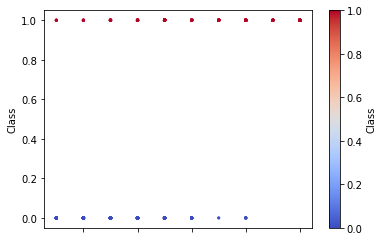

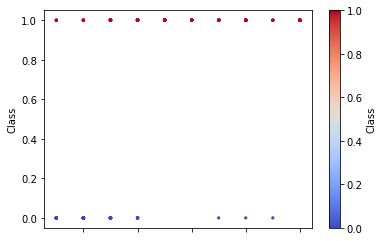

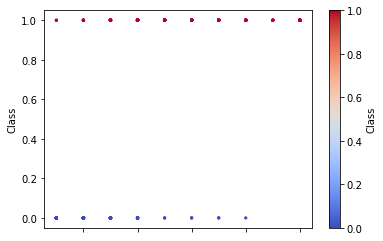

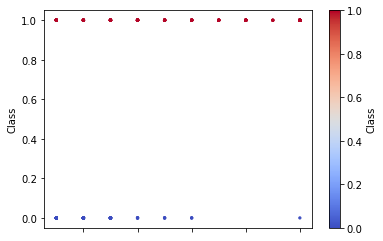

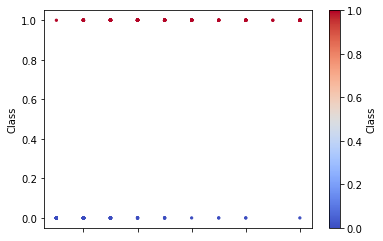

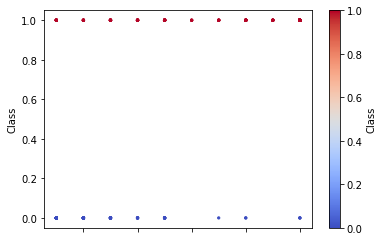

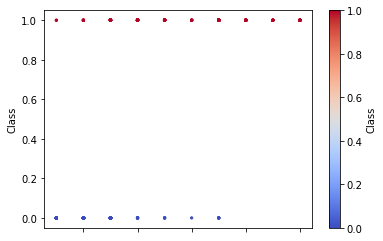

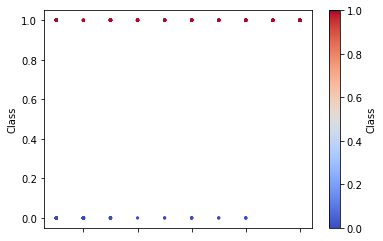

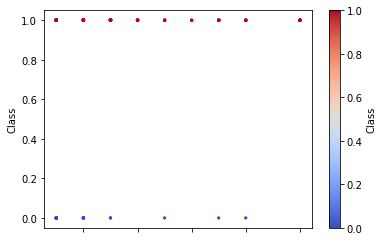

In [4]:
for col in bc_data.columns:
    if col != 'Class':
        bc_data.plot.scatter(col, 'Class', c='Class', xlabel = str(col), colormap='coolwarm', marker='.')

We then can look at the bar plots, highlighting the frequency of malignity with different values.

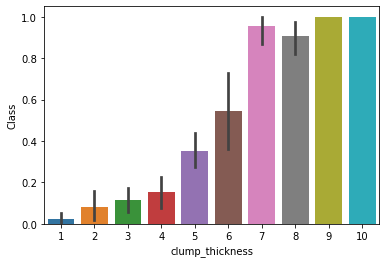

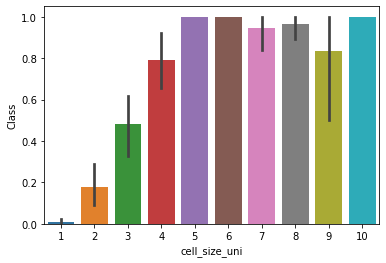

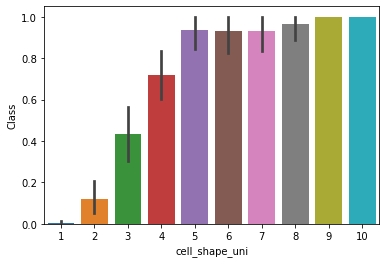

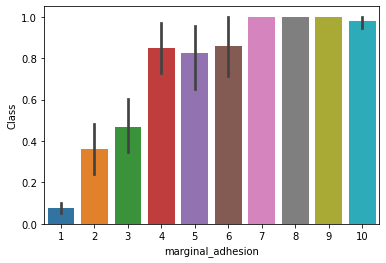

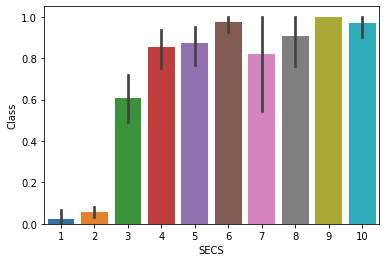

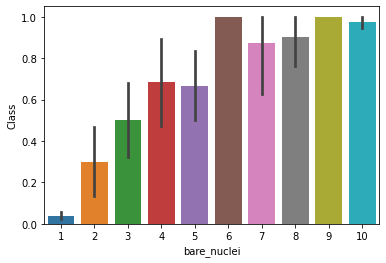

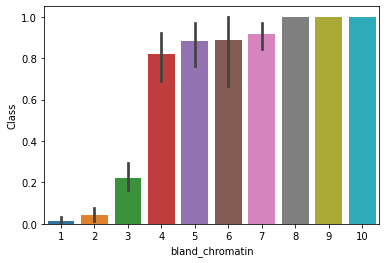

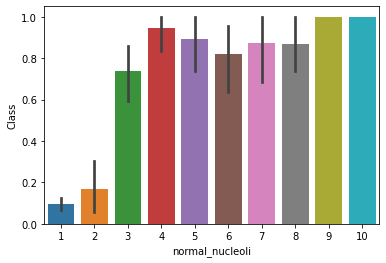

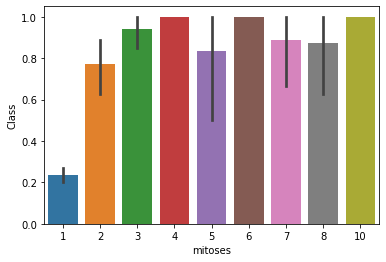

In [5]:
for col in bc_data.columns:
    if col != 'Class':
        plt.figure()
        sns.barplot(x = bc_data[col], y = bc_data['Class'])
        plt.show()

We can also look at the distribution of the values based on the class with a boxplot.

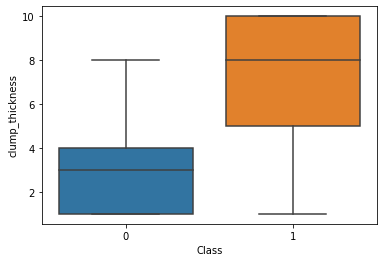

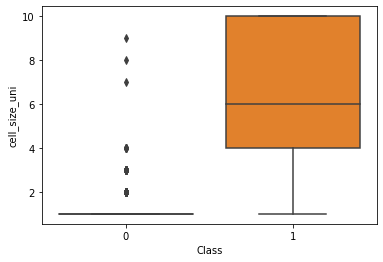

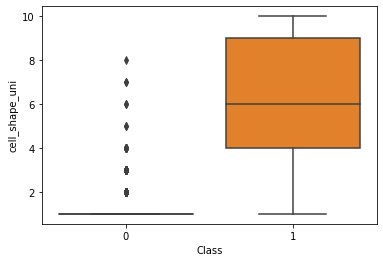

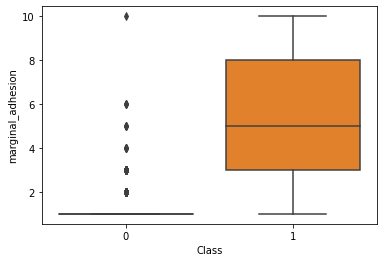

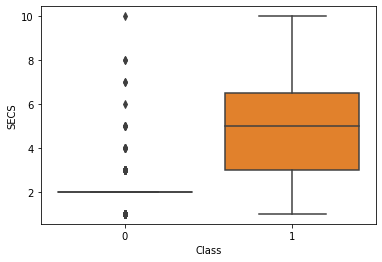

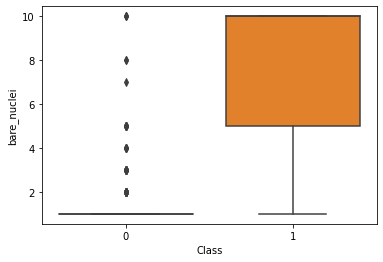

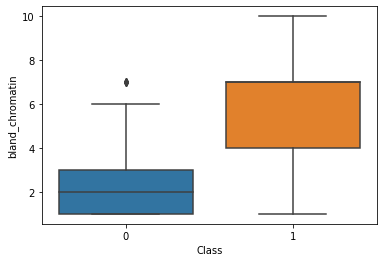

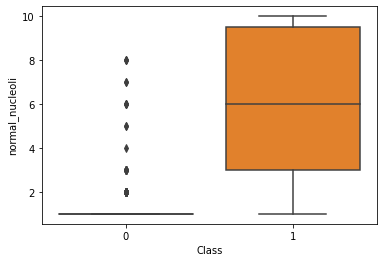

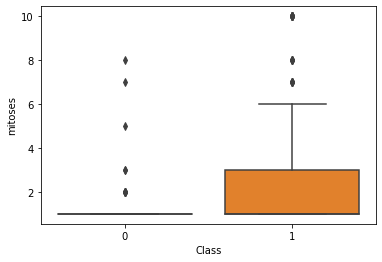

In [6]:
for col in bc_data.columns:
    if col != 'Class':
        plt.figure()
        sns.boxplot(x = bc_data['Class'], y = bc_data[col])
        plt.show()

We can then look at a pairplot and we can see that higher values in the different features are associated with the presence of cancer. The values of the different pairs are all not linearly separable.

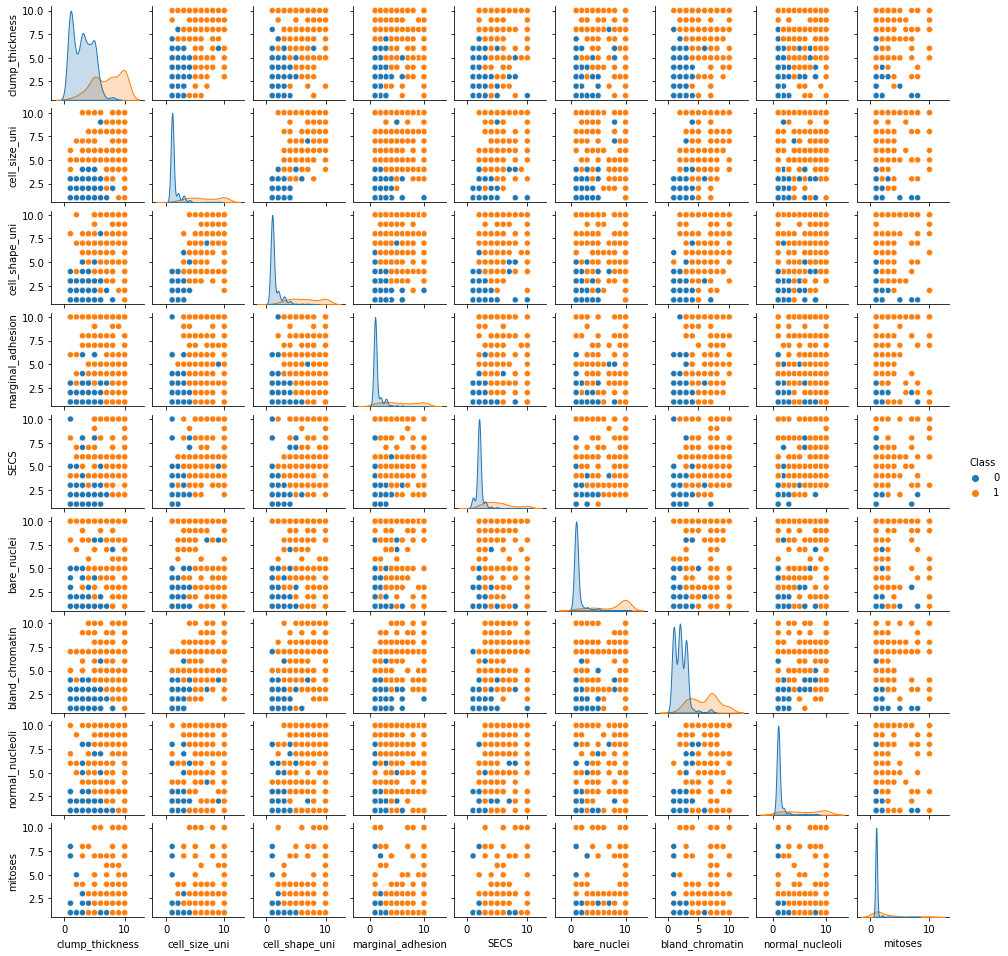

In [7]:
sns.pairplot(bc_data, height=1.5, vars = [f for f in bc_data.columns if f != 'Class'], hue = 'Class')

Then we can look at the correlation matrix, to highlight how the different features correlate with the class and with each other. We can see that cell size and shape highly correlate with each other and with the output feature, along with bare nuclei and bland chromatin.

[0.71478993 0.82080144 0.82189095 0.70629414 0.69095816 0.82269587
 0.75822755 0.71867719 0.42344792 1.        ]


<AxesSubplot:>

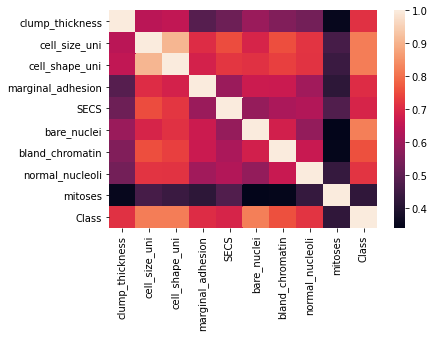

In [8]:
print(bc_data.corr().to_numpy()[:,-1])
sns.heatmap(bc_data.corr())

## Logistic regression

We can then start by implementing a logistic regression procedure. First, we define the accuracy score, which gives a numerical value to the strength of our prediction.

In [9]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

We can then employ a z-test procedure to see if the given coefficients are statistically significant or not.

In [10]:
def z_test(X, y, model, names, alpha=None):
    n_samples, n_features = X.shape
    betas = np.concatenate([model.intercept_, model.coef_.reshape(-1)])
    
    pred = model.predict_proba(X)
    y = y.reshape(-1)    
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    
    V = np.diagflat(np.product(pred, axis=1))
    covLogit = np.linalg.inv(np.dot(np.dot(X.T, V), X))
    se_b = np.sqrt(np.diag(covLogit)) 
    
    z_stat_b = (betas-0)/se_b

    p_values = np.array([2 * norm.sf(np.abs(z_stat)) for z_stat in z_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = np.round(se_b, decimals=4)
    df["Z-stat"] = np.round(z_stat_b, decimals=1)
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    return df

We have to split our data in train and test, keeping in mind that our dataset is unbalanced and so we have to stratify for the class values. 
We then can look at the statistical significance of all the variables, to see if there are some features that we can exclude. We can start with a very high threshold for the p-value (0.1), because the variables will undergo feature selection nonetheless. We see that the cell size and shape, along with the normal nucleoli, bland chromatin and the Single Epithelial Cell Size are not statistically significant.

In [11]:
X_full_features = [x for x in bc_data if x!= 'Class']
                                        
X_full = bc_data[X_full_features]

y = bc_data['Class'].to_numpy()

split_test_size = 0.3
split_seed = 42

X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y,
                                                                        test_size=split_test_size,
                                                                        random_state=split_seed, stratify = y)

model_full = LogisticRegression(solver='newton-cg', penalty='none') 
model_full.fit(X_full_train, y_full_train)                               
y_full_predict = model_full.predict(X_full_train)                        

print("Full model train accuracy:", accuracy(y_full_train, model_full.predict(X_full_train)))
print("Full model test accuracy:", accuracy(y_full_test, model_full.predict(X_full_test)), '\n')

print('The frequency of class 0 in the full dataset is:', len([x for x in bc_data['Class'] if x == 0])/len(bc_data['Class']))
print('The frequency of class 0 in the training group is:', len([x for x in y_full_train if x == 0])/len(y_full_train))
print('The frequency of class 0 in the test group is:', len([x for x in y_full_test if x == 0])/len(y_full_test))

Full model train accuracy: 0.9769874476987448
Full model test accuracy: 0.9560975609756097 

The frequency of class 0 in the full dataset is: 0.6500732064421669
The frequency of class 0 in the training group is: 0.6506276150627615
The frequency of class 0 in the test group is: 0.6487804878048781


In [12]:
z_test(X_full_train, y_full_train, model_full, ["Intercept", *X_full_features], alpha=0.1)

,Name,Coefficients,Standard Errors,Z-stat,p-value,reject H0
0,Intercept,-11.067714,1.7482,-6.3,2.435595e-10,True
1,clump_thickness,0.519762,0.1848,2.8,4.922158e-03,True
2,cell_size_uni,0.297884,0.3691,0.8,4.196841e-01,False
3,cell_shape_uni,0.318979,0.4096,0.8,4.361209e-01,False
4,marginal_adhesion,0.295986,0.1631,1.8,6.952825e-02,True
5,SECS,0.190249,0.2123,0.9,3.702208e-01,False
6,bare_nuclei,0.643503,0.1527,4.2,2.508481e-05,True
7,bland_chromatin,0.128849,0.2399,0.5,5.912353e-01,False
8,normal_nucleoli,0.188209,0.1560,1.2,2.275622e-01,False
9,mitoses,0.713280,0.3282,2.2,2.975578e-02,True


By removing the features with the highest p-values we can see that now all the features are statistically significant even with a much lower threshold (0.01).

In [13]:
X_subset_features = ['clump_thickness', 'bare_nuclei', 'marginal_adhesion', 'mitoses']
                                        
X_subset = bc_data[X_subset_features]

X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(X_subset, y,
                                                                        test_size=split_test_size,
                                                                        random_state=split_seed, stratify = y)

model_subset = LogisticRegression(solver='newton-cg', penalty='none') 
model_subset.fit(X_subset_train, y_subset_train)                               
y_subset_predict = model_subset.predict(X_subset_train)                        

print("Subset model train accuracy:", accuracy(y_subset_train, model_subset.predict(X_subset_train)))
print("Subset model test accuracy:", accuracy(y_subset_test, model_subset.predict(X_subset_test)))

Subset model train accuracy: 0.9728033472803347
Subset model test accuracy: 0.9414634146341463


In [14]:
z_test(X_subset_train, y_subset_train, model_subset, ["Intercept", *X_subset_features], alpha=0.01)

,Name,Coefficients,Standard Errors,Z-stat,p-value,reject H0
0,Intercept,-10.424083,1.4355,-7.3,3.819867e-13,True
1,clump_thickness,0.834292,0.1688,4.9,7.688170e-07,True
2,bare_nuclei,0.820046,0.1294,6.3,2.350706e-10,True
3,marginal_adhesion,0.659291,0.1456,4.5,5.950220e-06,True
4,mitoses,0.735817,0.2673,2.8,5.900365e-03,True


### Feature selection

A feature selection technique that can be employed is the Lasso feature selection, by applying a penalty to the logistic regression function, and, by the geometrical shape of the constrain, we can eliminate some features, based on the penalty. We can try to modify the penalty in order to see what features go to 0 before (less meaningful) and what features instead go to 0 last (the most meaningful ones).

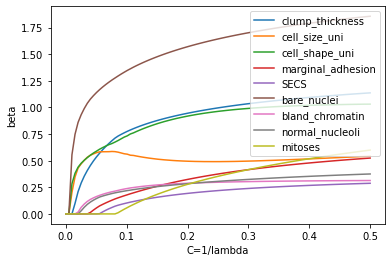

In [15]:
C_vals = np.linspace(1e-4, 0.5, 100)
betas = []

X_std = preprocessing.scale(X_full_train)

for C in C_vals:
    model_lasso = LogisticRegression(solver='saga', penalty='l1', C=C, max_iter = 10000)
    _ = model_lasso.fit(X_std, y_full_train)
    beta = model_lasso.coef_.reshape(-1)
    
    betas.append(beta)
betas = np.stack(betas, axis=1) 

for beta, name in zip(betas, X_full_features):
    _ = plt.plot(C_vals, beta, label=name)
_ = plt.legend(loc = 'upper right')
_ = plt.xlabel("C=1/lambda")
_ = plt.ylabel("beta")

In [16]:
d = {}

for beta, name in zip(betas, X_full_features):
    beta_no_0 = [n for n in beta if n != 0.0]
    d[name] = len(beta_no_0)                    # selecting the number of non-zero coefficients per feature

sorted_features = sorted(d, key=d.get)[::-1]    # ordering the features with respect to the number of non-zero coefficients (which means ordering for importance)

# creating a dictionary with, for every model computed by adding one feature at a time (in order of importance), the associated accuracy score

scores = {}

for i in range(1, len(sorted_features)+1):
    features = sorted_features[0:i]
    X_features = bc_data[features].to_numpy()
    y_features = bc_data['Class'].to_numpy()
    X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X_features, y_features,
                                                                                            test_size=split_test_size,
                                                                                            random_state=split_seed, stratify = y)

    model_l = LogisticRegression(solver='newton-cg', penalty='none')                       
    model_l = model_l.fit(X_train_features, y_train_features)      
    y_predict_test_features = model_l.predict(X_test_features)     
    y_predict_train_features = model_l.predict(X_train_features)
    
    scores[i] = [accuracy(y_test_features, y_predict_test_features)]


acc_score = None
X_lasso_features = None

for score in scores.items():
    if X_lasso_features is None:
        acc_score = score[1]
        X_lasso_features = sorted_features[0:score[0]]
    else:
        if score[1] > acc_score:
            acc_score = score[1]
            X_lasso_features = sorted_features[0:score[0]]
            
print('The best model has:', len(X_lasso_features), 'features')
print('The best model is:', X_lasso_features)
print('The associated test accuracy score is:', acc_score)

The best model has: 8 features
The best model is: ['bare_nuclei', 'cell_shape_uni', 'cell_size_uni', 'clump_thickness', 'bland_chromatin', 'normal_nucleoli', 'marginal_adhesion', 'SECS']
The associated test accuracy score is: [0.9658536585365853]


With the Lasso feature selection we see that the best model is still the one that considers all the different features. We can see that bare nuceli, cell shape and size and clump thickness are the most relevant ones.

### Degree analysis

We can also analyse the best degree for the features, by a GridSearchCV method. We can see by the table below that the best degree is one when considering accuracy as the score.

In [17]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    best_idx = np.argmax(results['mean_test_score'])
    
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx], marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) test:", accuracy(y_full_test, cv.best_estimator_.predict(X_test)))

In [18]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LogisticRegression())])
params = {'poly__degree': range(1, 5)}
cv_accuracy = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring='accuracy')

cv_accuracy.fit(X_full_train, y_full_train)

pd.DataFrame(cv_accuracy.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048001,0.011135,0.006600,0.000801,1,{'poly__degree': 1},0.958333,0.958333,0.937500,1.000000,0.979167,0.979167,0.979167,0.979167,0.978723,0.957447,0.970700,0.016713,1
1,0.084902,0.009587,0.005499,0.002693,2,{'poly__degree': 2},0.958333,0.895833,0.937500,0.958333,0.958333,1.000000,0.895833,0.937500,0.957447,0.957447,0.945656,0.029683,3
2,0.086201,0.013449,0.004301,0.000640,3,{'poly__degree': 3},0.979167,0.895833,0.916667,0.979167,0.937500,1.000000,0.916667,0.937500,0.957447,0.957447,0.947739,0.031193,2
3,0.211507,0.018401,0.004894,0.000943,4,{'poly__degree': 4},0.916667,0.958333,0.875000,0.979167,0.916667,1.000000,0.875000,0.937500,0.957447,0.957447,0.937323,0.039437,4


By looking at the best degree considering the Area Under the ROC Curve (more on this later), we get again the best degree of 1.

In [19]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LogisticRegression())])
params = {'poly__degree': range(1, 5)}
cv_roc = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(roc_auc_score))

cv_roc.fit(X_full_train, y_full_train)

pd.DataFrame(cv_roc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033498,0.008768,0.005802,0.002182,1,{'poly__degree': 1},0.953125,0.941176,0.938330,1.000000,0.970588,0.970588,0.983871,0.983871,0.983871,0.9375,0.966292,0.021249,1
1,0.059201,0.007794,0.005601,0.001198,2,{'poly__degree': 2},0.937500,0.892789,0.925047,0.941176,0.941176,1.000000,0.892789,0.911765,0.967742,0.9375,0.934749,0.030964,3
2,0.083302,0.005160,0.006799,0.002090,3,{'poly__degree': 3},0.968750,0.892789,0.908918,0.970588,0.911765,1.000000,0.908918,0.911765,0.967742,0.9375,0.937874,0.034421,2
3,0.207609,0.019686,0.006392,0.001430,4,{'poly__degree': 4},0.890625,0.954459,0.836812,0.970588,0.895636,1.000000,0.863378,0.911765,0.967742,0.9375,0.922850,0.049297,4


Lastly, we can check the best degree for what regards the recall, or sensitivity (more on this later). Again, we get the best degree of one.

In [20]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LogisticRegression())])
params = {'poly__degree': range(1, 5)}
cv_recall = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring='recall')

cv_recall.fit(X_full_train, y_full_train)

pd.DataFrame(cv_recall.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032799,0.007401,0.005601,0.001686,1,{'poly__degree': 1},0.9375,0.882353,0.941176,1.000000,0.941176,0.941176,1.000000,1.000000,1.0,0.875,0.951838,0.045340,1
1,0.066400,0.008088,0.005699,0.001100,2,{'poly__degree': 2},0.8750,0.882353,0.882353,0.882353,0.882353,1.000000,0.882353,0.823529,1.0,0.875,0.898529,0.053510,3
2,0.083801,0.011907,0.006299,0.001554,3,{'poly__degree': 3},0.9375,0.882353,0.882353,0.941176,0.823529,1.000000,0.882353,0.823529,1.0,0.875,0.904779,0.060107,2
3,0.224907,0.030909,0.006993,0.001734,4,{'poly__degree': 4},0.8125,0.941176,0.705882,0.941176,0.823529,1.000000,0.823529,0.823529,1.0,0.875,0.874632,0.089701,4


 Accuracy score (best 1) CV: 0.9707003546099292
 Accuracy score (best 1) test: 0.9560975609756097
 AUC score (best 1) CV: 0.9662921015180267
 AUC score (best 1) test: 0.9560975609756097
 Recall score (best 1) CV: 0.9518382352941176
 Recall score (best 1) test: 0.9560975609756097


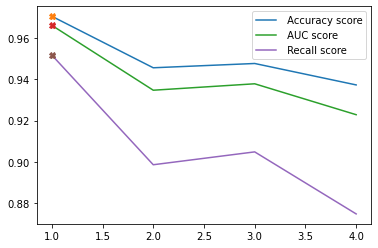

In [21]:
show_results(cv_accuracy, X_full_test, 'param_poly__degree', 'Accuracy score')
show_results(cv_roc, X_full_test, 'param_poly__degree', 'AUC score')
show_results(cv_recall, X_full_test, 'param_poly__degree', 'Recall score')

## Linear discriminant analysis

After the Logistic Regression analysis, we can employ a Linear Discriminant Analysis, which uses the Bayes theorem and models the posterior probability. If the exact feature distribution is found, the perfect Bayes classifier is obtained.

We can try to look at a model with only the bare nuclei and the bland chromatin, since they are the two most correlated features among the ones that were present in all models (z-test and feature selection). This two features will be used throughout the analysis only with representation porpuses, they are not intended as the best model with two features or the best model overall.

In [22]:
X_two_feat = ['clump_thickness', 'bare_nuclei']
X_two = bc_data[X_two_feat]

X_two_lda_train, X_two_lda_test, y_two_lda_train, y_two_lda_test = train_test_split(X_two, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed, stratify = y)

model_two_lda = LDA(store_covariance=True)
model_two_lda = model_two_lda.fit(X_two_lda_train, y_two_lda_train)

print("Train accuracy:", accuracy(y_two_lda_train, model_two_lda.predict(X_two_lda_train)))
print("Test accuracy:", accuracy(y_two_lda_test, model_two_lda.predict(X_two_lda_test)))

Train accuracy: 0.9476987447698745
Test accuracy: 0.8829268292682927


We can plot the distributions using confidence ellipses, which represent a sort of confidence interval. A 95% confidence ellipses defines the region that contains 95% of all samples that can be drawn from the underlying Gaussian distribution.

In [23]:
def plot_gaussian(model, mu, covar, x, y=None, n_stdev_bands=2):
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if covar.ndim == 2:
        covar = np.repeat(covar[None], mu.shape[0], axis=0)
        
    ax = plt.subplot(111, aspect='equal')
    legend = []
    
    if mu.shape[-1] == 2:
        
        variance, transforms = np.linalg.eigh(covar)
        
        stdev = np.sqrt(variance)
        
        max_x, min_x, max_y, min_y = 0.0, 0.0, 0.0, 0.0
        cmap = cm.rainbow(np.linspace(0, 1, mu.shape[0]))
        for mean, stdev, transform, color in zip(mu, stdev, transforms, cmap):
            
            legend += [mpatches.Patch(color=color,
                                      label=f'mu {mean[0]:.2f}, {mean[1]:.2f} '
                                      f'sigma {stdev[0]:.2f} {stdev[1]:.2f}')]
            
            for j in range(1, n_stdev_bands + 1):
                
                ell = mpatches.Ellipse(xy=(mean[0], mean[1]), 
                                       
                                       width=stdev[0] * j * 2, height=stdev[1] * j * 2,
                                       
                                       angle=degrees(atan(transform[0, 1] / transform[0, 0])),
                                       
                                       alpha=1.0, edgecolor=color, fc='none')
                ax.add_artist(ell)
                
                max_x = max(max_x, mean[0] + stdev[0] * j * 1.5)
                max_y = max(max_y, mean[1] + stdev[1] * j * 1.5)
                min_x = min(min_x, mean[0] - stdev[0] * j * 1.5)
                min_y = min(min_y, mean[1] - stdev[1] * j * 1.5)
    else:
        
        max_x, min_x = x[:, 0].max()+x[:, 0].ptp()/2, x[:, 0].min()-x[:, 0].ptp()/2
        max_y, min_y = x[:, 1].max()+x[:, 1].ptp()/2, x[:, 1].min()-x[:, 1].ptp()/2
        
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 1000),
                         np.linspace(min_y, max_y, 1000))
    
    X_fake = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    
    Z = model.predict_proba(X_fake)
    
    Z = Z[:, 1].reshape(xx.shape)
    
    cmap_light = colors.ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_solid = colors.ListedColormap(['#0000FF', '#FF0000'])
    
    plt.contour(xx, yy, Z, [0.5], colors='grey')
    
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_solid)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    plt.gca().set_aspect('equal', adjustable='box')
    if legend:
        plt.legend(handles=legend)

    plt.show()


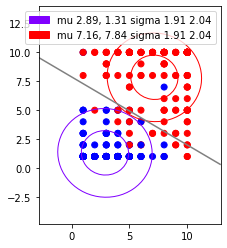

In [24]:
plot_gaussian(model_two_lda, model_two_lda.means_, model_two_lda.covariance_, X_two_lda_train, y_two_lda_train)

### Degree analysis

We can then look at different degrees of the selected features and try to find the best degree. We can start by looking at degree two and the relative gaussian plot.

In [25]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lda', LDA(store_covariance=True))])
model_pol_lda = model.fit(X_two_lda_train.to_numpy(), y_two_lda_train)

print("Train accuracy:", accuracy(y_two_lda_train, model_pol_lda.predict(X_two_lda_train.to_numpy())))
print("Test accuracy:", accuracy(y_two_lda_test, model_pol_lda.predict(X_two_lda_test.to_numpy())))

Train accuracy: 0.9497907949790795
Test accuracy: 0.926829268292683


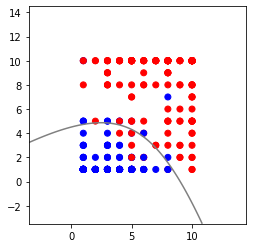

In [26]:
lda_model = model_pol_lda.steps[-1][-1]
plot_gaussian(model_pol_lda, lda_model.means_, lda_model.covariance_, X_two_lda_train, y=y_two_lda_train)

We can then assess which is the best degree of all features with GridSearch, and by the table below we can see that it is one, for what regards the accuracy score.

In [27]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 5)}
cv_accuracy = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring='accuracy')

cv_accuracy.fit(X_full_train, y_full_train)

pd.DataFrame(cv_accuracy.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016798,0.003940,0.005599,0.000917,1,{'poly__degree': 1},0.979167,0.958333,0.916667,1.000000,0.958333,0.979167,0.958333,0.979167,0.978723,0.957447,0.966534,0.021257,1
1,0.025700,0.005478,0.005901,0.001445,2,{'poly__degree': 2},0.958333,0.937500,0.937500,1.000000,0.979167,0.979167,0.937500,0.979167,0.978723,0.957447,0.964450,0.020935,2
2,0.081501,0.005937,0.006102,0.001513,3,{'poly__degree': 3},0.854167,0.750000,0.791667,0.875000,0.833333,0.895833,0.833333,0.791667,0.893617,0.851064,0.836968,0.045066,4
3,0.233097,0.023632,0.005706,0.000784,4,{'poly__degree': 4},0.854167,0.791667,0.854167,0.833333,0.812500,0.833333,0.812500,0.854167,0.872340,0.872340,0.839051,0.025734,3


When looking at the Area Under the ROC Curve we get the best degree of 1.

In [28]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA())])
params = {'poly__degree': range(1, 5)}
cv_roc = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(roc_auc_score))

cv_roc.fit(X_full_train, y_full_train)

pd.DataFrame(cv_roc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012398,0.004317,0.006401,0.001743,1,{'poly__degree': 1},0.968750,0.941176,0.895636,1.000000,0.941176,0.970588,0.954459,0.970588,0.983871,0.93750,0.956375,0.027798,1
1,0.017900,0.002548,0.005901,0.001448,2,{'poly__degree': 2},0.953125,0.925047,0.925047,1.000000,0.970588,0.970588,0.925047,0.970588,0.983871,0.93750,0.956140,0.025643,2
2,0.058901,0.006157,0.005900,0.000944,3,{'poly__degree': 3},0.812500,0.673624,0.719165,0.823529,0.777989,0.852941,0.817837,0.732448,0.843750,0.78125,0.783503,0.055613,4
3,0.196297,0.018084,0.007004,0.001732,4,{'poly__degree': 4},0.812500,0.759013,0.820683,0.777989,0.761860,0.764706,0.775142,0.833966,0.827621,0.81250,0.794598,0.028014,3


Lastly, we check the best degree for recall, and we get that the best degree is 2 this time.

In [29]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA())])
params = {'poly__degree': range(1, 5)}
cv_recall = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring='recall')

cv_recall.fit(X_full_train, y_full_train)

pd.DataFrame(cv_recall.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012502,0.004178,0.006098,0.002663,1,{'poly__degree': 1},0.9375,0.882353,0.823529,1.000000,0.882353,0.941176,0.941176,0.941176,1.0000,0.8750,0.922426,0.053441,2
1,0.016902,0.002844,0.006199,0.001249,2,{'poly__degree': 2},0.9375,0.882353,0.882353,1.000000,0.941176,0.941176,0.882353,0.941176,1.0000,0.8750,0.928309,0.044764,1
2,0.057000,0.007614,0.006100,0.001300,3,{'poly__degree': 3},0.6875,0.411765,0.470588,0.647059,0.588235,0.705882,0.764706,0.529412,0.6875,0.5625,0.605515,0.106897,4
3,0.190700,0.010900,0.006102,0.001580,4,{'poly__degree': 4},0.6875,0.647059,0.705882,0.588235,0.588235,0.529412,0.647059,0.764706,0.6875,0.6250,0.647059,0.064668,3


 Accuracy score (best 1) CV: 0.9665336879432624
 Accuracy score (best 1) test: 0.9365853658536586
 AUC score (best 1) CV: 0.9563745256166983
 AUC score (best 1) test: 0.9365853658536586
 Recall score (best 2) CV: 0.9283088235294118
 Recall score (best 2) test: 0.9512195121951219


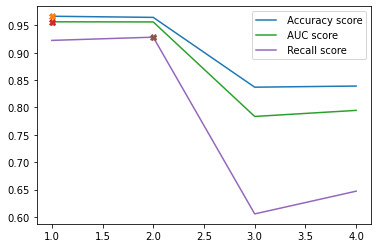

In [30]:
show_results(cv_accuracy, X_full_test, 'param_poly__degree', 'Accuracy score')
show_results(cv_roc, X_full_test, 'param_poly__degree', 'AUC score')
show_results(cv_recall, X_full_test, 'param_poly__degree', 'Recall score')

## Quadratic discriminant analysis

When the LDA assumption that the density functions have the same covariance matrix doesn't hold, we obtain a quadratic relation (QDA). The test accuracy is slightly lower than LDA/Logistic Eegression. 
In order to look at the plot, we use again a simple two-features model. The full model with the QDA analysis will be presented in the 'Model comparison' section.

Train accuracy: 0.9497907949790795
Test accuracy: 0.9317073170731708


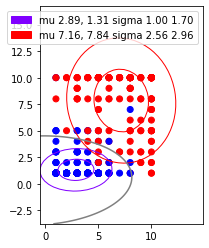

In [31]:
X_two_feat = ['clump_thickness', 'bare_nuclei']
X_two = bc_data[X_two_feat]

X_two_qda_train, X_two_qda_test, y_two_qda_train, y_two_qda_test = train_test_split(X_two, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed, stratify = y)

model_qda = QDA(store_covariance = True)
model_qda = model_qda.fit(X_two_qda_train.to_numpy(), y_two_qda_train)

print("Train accuracy:", accuracy(y_two_qda_train, model_qda.predict(X_two_qda_train.to_numpy())))
print("Test accuracy:", accuracy(y_two_qda_test, model_qda.predict(X_two_qda_test.to_numpy())))

plot_gaussian(model_qda, model_qda.means_, np.stack(model_qda.covariance_, axis=0), X_two_qda_train, y_two_qda_train, 2)

## K-nearest neighbors

Another useful classification method is the K-nearest neighbors (KNN), which, contrary to the ones used before, is a non-parametric method.

The KNN classifies a point based on the label of the majority of the K nearest points. 

Again, we start by looking at the model with two features (the two most correlated numerical features), in order to better visualize the plots. We also start with 1 K nearest neighbor.

In [32]:
X_two_feat = ['clump_thickness', 'bare_nuclei']
X_two = bc_data[X_two_feat]

X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_two, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed, stratify = y)

model_one_knn = KNeighborsClassifier(1)
model_one_knn.fit(X_knn_train, y_knn_train)

print("Train accuracy:", accuracy(y_knn_train, model_one_knn.predict(X_knn_train)))
print("Test accuracy:", accuracy(y_knn_test, model_one_knn.predict(X_knn_test)))

Train accuracy: 0.9707112970711297
Test accuracy: 0.9317073170731708


We can also see that the train score is not one, which was not expected since the neighbors considered are only one (the point itself). This might be due to a repetition of values, which can be frequent since we are considering only two variables with a limited number of possible values. Given that we will consider more than two features in the actual analysis, and the duplicates will then be much less frequent, the analysis to eliminate the duplicates will be shown but not run.

In [33]:
# y_knn_pred = model_one_knn.predict(X_knn_train)

# X_knn_train[y_knn_pred != y_knn_train]

In [34]:
#X_knn_train[X_knn_train.duplicated()]

In [35]:
# unique_mask = y_knn_train == model_one_knn.predict(X_knn_train)
# X_knn_train_unique = X_knn_train[unique_mask]
# y_knn_train_unique = y_knn_train[unique_mask]

# model_one_knn.fit(X_knn_train_unique, y_knn_train_unique)

# print("Train accuracy:", accuracy(y_knn_train_unique, model_one_knn.predict(X_knn_train_unique)))
# print("Test accuracy:", accuracy(y_knn_test, model_one_knn.predict(X_knn_test)))

We can assess which is the best K parameter by cross validation, and we do that by looking at the whole set of features. From the plot below we can see that the best K is 3, when using accuracy, recall or the Area Under the ROC Curve as the scorer. Such a low K hints that data are not linearly separable.

In [36]:
model_knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 15)}

cv_accuracy = GridSearchCV(model_knn, params, cv=10, 
                  scoring='accuracy')

cv_accuracy.fit(X_full_train, y_full_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 15)}, scoring='accuracy')

In [37]:
model_knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 15)}

cv_roc = GridSearchCV(model_knn, params, cv=10, 
                  scoring=make_scorer(roc_auc_score))

cv_roc.fit(X_full_train, y_full_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 15)},
             scoring=make_scorer(roc_auc_score))

In [38]:
model_knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 15)}

cv_recall = GridSearchCV(model_knn, params, cv=10, 
                  scoring='recall')

cv_recall.fit(X_full_train, y_full_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 15)}, scoring='recall')

 Accuracy score (best 3) CV: 0.9811613475177305
 Accuracy score (best 3) test: 0.9560975609756097
 AUC score (best 3) CV: 0.9771465844402277
 AUC score (best 3) test: 0.9560975609756097
 Recall score (best 3) CV: 0.9639705882352942
 Recall score (best 3) test: 0.9560975609756097


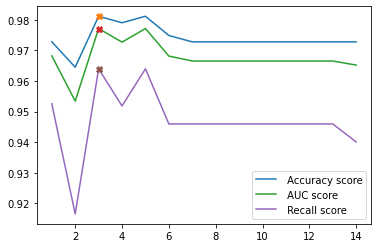

In [39]:
show_results(cv_accuracy, X_full_test, "param_n_neighbors", 'Accuracy score')
show_results(cv_roc, X_full_test, "param_n_neighbors", 'AUC score')
show_results(cv_recall, X_full_test, "param_n_neighbors", 'Recall score')

Using K equal to 3 we get an higher test accuracy score, with respect to K equal to 1.

In [40]:
model_three_knn = KNeighborsClassifier(3)
model_three_knn.fit(X_full_train, y_full_train)

print("Train accuracy:", accuracy(y_full_train, model_three_knn.predict(X_full_train)))
print("Test accuracy:", accuracy(y_full_test, model_three_knn.predict(X_full_test)))

Train accuracy: 0.9874476987447699
Test accuracy: 0.9560975609756097


We can then plot the KNN boundaries (only on the two selected features, for representation purposes) on the data points.

In [41]:
def show_boundary(model, X, y=None):
    if not isinstance(X, np.ndarray):
        X = np.array(X)
        
    max_x, min_x = X[:, 0].max()+X[:, 0].ptp()/3, X[:, 0].min()-X[:, 0].ptp()/3
    max_y, min_y = X[:, 1].max()+X[:, 1].ptp()/3, X[:, 1].min()-X[:, 1].ptp()/3
    
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 300),
                         np.linspace(min_y, max_y, 300))
    
    X_grid= np.stack([xx.reshape(-1), yy.reshape(-1)], axis=-1) 
    
    predict_grid = model.predict(X_grid)
    
    predict_grid = predict_grid.reshape(xx.shape)
    plt.figure()
    
    cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_solid = ListedColormap(['#0000FF', '#FF0000'])
    plt.pcolormesh(xx, yy, predict_grid,
                   cmap=cmap_light, norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, predict_grid, [0.5], colors='grey')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_solid)

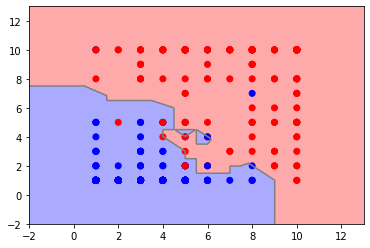

In [42]:
model_three_knn = KNeighborsClassifier(3)
model_three_knn.fit(X_knn_train, y_knn_train)

show_boundary(model_three_knn, X_knn_train, y_knn_train)

### Normalization

KNN relies on sample distances to perform prediction, so having normalized features that span on the same range allows samples to be compared more reliably.

To compare the different KNN models, accuracy will be used. Recall and AUC will also be used in the overall model comparison.

We can see that with the whole model and the KNN with normalized data, we get a test score of around 0.96. In the case of the minmax scalere the score is the same score we get with the unnormalized KNN, because being the differnet features on the same interval minmax simply is a multiplication by a factor, so it is useless. KNN unnormalized performs a little better than the standardized model.

 Unnormalized (best 3) CV: 0.9811613475177305
 Unnormalized (best 3) test: 0.9560975609756097
 StandardScaler (best 3) CV: 0.9727412280701755
 StandardScaler (best 3) test: 0.9414634146341463
 MinMaxScaler (best 3) CV: 0.9769736842105263
 MinMaxScaler (best 3) test: 0.9560975609756097


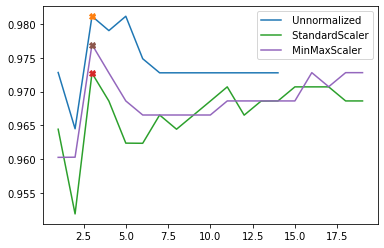

In [43]:
params = {'knn__n_neighbors': range(1, 20)}
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())])
cv_std = GridSearchCV(model_std, params, n_jobs=10, refit=True, cv=5,
                     scoring='accuracy')
cv_std.fit(X_full_train, y_full_train)

model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())])
cv_minmax = GridSearchCV(model_minmax, params, n_jobs=10, refit=True, cv=5,
                        scoring='accuracy')
cv_minmax.fit(X_full_train, y_full_train)

show_results(cv_accuracy, X_full_test, "param_n_neighbors", prefix="Unnormalized")
show_results(cv_std, X_full_test, 'param_knn__n_neighbors', "StandardScaler")
show_results(cv_minmax, X_full_test, 'param_knn__n_neighbors', "MinMaxScaler")

## Support vector machine

Another useful tool is the support vector machine (SVM), which, unlike LDA or Logistic regression, is a discriminative approach. It doesn't make assumptions on the data distribution, but defines a discriminating function and optimizes it.

In order to better look at the plots, we'll start with a simple two features example, choosing the two highest correlated features.

In [44]:
X_svm = bc_data[['clump_thickness', 'bare_nuclei']].to_numpy()
y = bc_data['Class'].to_numpy()

X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X_svm, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed, stratify = y)

model_svm = SVC(kernel='linear', C=5) # C indicates a regularizing penalty to account for errors in a non separable case (as might be this one, since our data is complex). 5 is used as an example
model_svm.fit(X_svm_train, y_svm_train)

train_acc = accuracy_score(model_svm.predict(X_svm_train), y_svm_train)
test_acc = accuracy_score(model_svm.predict(X_svm_test), y_svm_test)

print("SVM train accuracy:", train_acc)
print("SVM test accuracy:", test_acc)

SVM train accuracy: 0.9581589958158996
SVM test accuracy: 0.9317073170731708


We can look at the scatter-plot.

<AxesSubplot:xlabel='clump_thickness', ylabel='bare_nuclei'>

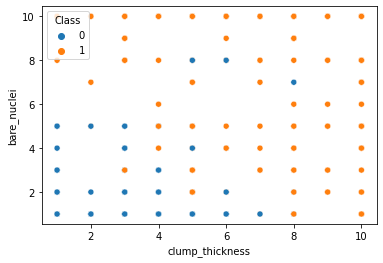

In [45]:
sns.scatterplot(x='clump_thickness', y='bare_nuclei', data=bc_data, hue='Class')

To visualize the SVM boundary.

In [46]:
def plot_svm_line(model, Xrange, Yrange, label=None):
    Xmin, Xmax = Xrange
    Ymin, Ymax = Yrange
    
    xx = np.linspace(Xmin, Xmax, 100)
    yy = np.linspace(Ymin, Ymax, 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.reshape(-1), YY.reshape(-1)]).T
    Z =  model.decision_function(xy).reshape(XX.shape)
    
    c = plt.contour(XX, YY, Z, colors='g', 
                levels=[-1, 0, 1],
                linestyles=["--", "-", "--"])
    c.collections[1].set_label(label)
    
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=100, linewidth=1, facecolors='none', edgecolors='k')

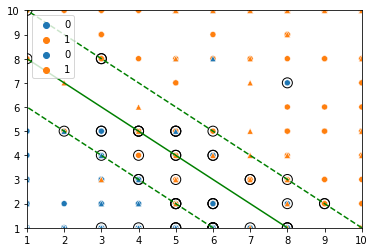

In [47]:
X0_range = (X_svm_train[:,0].min(), X_svm_train[:,0].max())
X1_range = (X_svm_train[:,1].min(), X_svm_train[:,1].max())

sns.scatterplot(x=X_svm_train[:,0], y=X_svm_train[:,1], hue=y_svm_train, marker='o')
sns.scatterplot(x=X_svm_test[:,0], y=X_svm_test[:,1], hue=y_svm_test, marker='^')
plot_svm_line(model_svm, X0_range, X1_range)

In [48]:
def plot_linear_line(model, Xrange, label=None):
    Xmin, Xmax = Xrange
    w0, = model.intercept_
    w1, w2 = model.coef_.flatten()

    x1, y1 = Xmin, -(w0 + w1 * Xmin) / w2
    x2, y2 = Xmax, -(w0 + w1 * Xmax) / w2
    sns.lineplot(x=[x1, x2], y=[y1, y2], label=label)

We can then look at a comparison between Logistic Regression, linear SVM and the Perceptron (which learns the parameters by minimizing the error function), that are all linear algorithms that hence as output a linear bound.

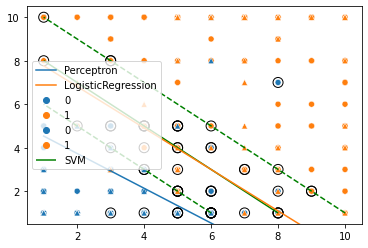

In [49]:
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_svm_train, y_svm_train)

pt_model = Perceptron()
pt_model.fit(X_svm_train, y_svm_train)

svm_model = SVC(kernel='linear', C=5)
svm_model.fit(X_svm_train, y_svm_train)


sns.scatterplot(x=X_svm_train[:,0], y=X_svm_train[:,1], hue=y_svm_train, marker='o')
sns.scatterplot(x=X_svm_test[:,0], y=X_svm_test[:,1], hue=y_svm_test, marker='^')

plot_svm_line(svm_model, X0_range, X1_range, label="SVM")
plot_linear_line(pt_model, X0_range, label="Perceptron")
plot_linear_line(lr_model, X0_range, label="LogisticRegression")
_ = plt.axis([X0_range[0]-0.5, X0_range[1]+0.5, X1_range[0]-0.5, X1_range[1]+0.5])

By looking at the scores, we can see that SVM and Logistic Regression perform in a very similar way (and are actually the same on train data), while the Perceptron performs a little worse, but has an accuracy well above 90% (even though the test accuracy is higher than the train accuracy). We know in fact that the Perceptron does not converge if the problem is not linearly separable, but in this case we have only a few points that don't allow the problem to be linearly separable.

In [50]:
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_full_train, y_full_train)

pt_model = Perceptron()
pt_model.fit(X_full_train, y_full_train)

svm_model = SVC(kernel='linear', C=10)
svm_model.fit(X_full_train, y_full_train)

for m in [svm_model, lr_model, pt_model]:
    train_acc = accuracy_score(y_full_train, m.predict(X_full_train))
    test_acc = accuracy_score(y_full_test, m.predict(X_full_test))
    print("{} train score: {}".format(m.__class__.__name__, train_acc))
    print("{} test score: {}".format(m.__class__.__name__, test_acc))

SVC train score: 0.9769874476987448
SVC test score: 0.9609756097560975
LogisticRegression train score: 0.9769874476987448
LogisticRegression test score: 0.9560975609756097
Perceptron train score: 0.9748953974895398
Perceptron test score: 0.9512195121951219


### Kernel trick

The kernel trick allows us to enlarge the feature space in order to accommodate a non-linear boundary between the classes. We can use different kernels (poly, RBF and sigmoid) and compare them.

We can first of all look at the polynomial kernel, with a degree of 2, and look at the plot.

Train score: 0.9288702928870293
Test score: 0.8634146341463415


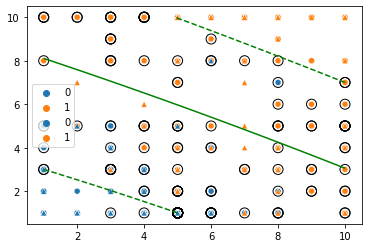

In [51]:
kernel_model = SVC(kernel='poly', degree=2, coef0=5, C=0.001)
kernel_model.fit(X_svm_train, y_svm_train)

sns.scatterplot(x=X_svm_train[:,0], y=X_svm_train[:,1], hue=y_svm_train, marker='o')
sns.scatterplot(x=X_svm_test[:,0], y=X_svm_test[:,1], hue=y_svm_test, marker='^')
plot_svm_line(kernel_model, X0_range, X1_range, label="SVM")
_ = plt.axis([X0_range[0]-0.5, X0_range[1]+0.5, X1_range[0]-0.5, X1_range[1]+0.5])

train_acc = accuracy_score(y_svm_train, kernel_model.predict(X_svm_train))
test_acc = accuracy_score(y_svm_test, kernel_model.predict(X_svm_test))
print("Train score: {}".format(train_acc))
print("Test score: {}".format(test_acc))

We can then apply Cross Validation on a number of different parameters on all the kernels, and then look at the results.

In [52]:
# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='accuracy', refit = True)
svm_poly.fit(X_full_train, y_full_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_svm= GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='accuracy', refit = True)
rbf_svm.fit(X_full_train, y_full_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_svm = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='accuracy', refit = True)
sigm_svm.fit(X_full_train, y_full_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='accuracy')

We can see that all the models perform around 0.95 in the test group, but the sigmoid and the RBF kernel perform a bit better on the test score (and they have actually the same score). They all have the same scores in CV.

In [53]:
for m in [svm_poly, rbf_svm, sigm_svm]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    train_acc = accuracy_score(y_full_train, m.predict(X_full_train))
    test_acc = accuracy_score(y_full_test, m.predict(X_full_test))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_acc))
    print("test score: {}\n".format(test_acc))

SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
cv score: 0.9728070175438596
train score: 0.9790794979079498
test score: 0.9560975609756097

SVC(C=25.00075, gamma=0.001)
cv score: 0.9728070175438596
train score: 0.9811715481171548
test score: 0.9609756097560975

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
cv score: 0.9728070175438596
train score: 0.9769874476987448
test score: 0.9609756097560975



## 2 features summary plots

We can then look at summary plots that show the behaviour of the models used in this analysis when considering only the two features that we have used: the clump thickness and the bare nuclei. Mind, these two features are not considered the best two features possible for all the models, they are just used with graphical representation purposes.

In [54]:
classifiers = [
    ("KNN", KNeighborsClassifier(), {"n_neighbors": range(1, 15)}),
    ("KNN_std", Pipeline([('norm', StandardScaler()), ('knn', KNeighborsClassifier())]), {"knn__n_neighbors": range(1, 15)}),
    ("Perceptron", Perceptron(), None),
    ("LR", LogisticRegression(fit_intercept=True), None),
    ("SVM_linear", SVC(kernel='linear'), {"C": np.linspace(0.0001, 100, 5)}),
    ("SVM_RBF", SVC(kernel='rbf'), {'C': np.linspace(0.001, 100, 5),
                                   'gamma': np.linspace(0.001, 100, 5),
                                   'coef0': np.linspace(-10, 10, 5)}),
    ("SVM_poly", SVC(kernel='poly'), {"C": np.linspace(0.001, 100, 5), 
                                     "degree": range(2,4),
                                     "coef0": np.linspace(-10, 10, 5)}),
    ("SVM_sigmoid", SVC(kernel='sigmoid'), {'C': np.linspace(0.001, 100, 5),
                                           'gamma': np.linspace(0.001, 100, 5),
                                           'coef0': np.linspace(-10, 10, 5)}),
    ("LDA", LDA(), None),
    ("LDA_poly", Pipeline([('poly', PolynomialFeatures()), 
                          ('lda', LDA())]), {"poly__degree": range(2, 4)}),
    ("QDA", QDA(), None)
]



The best parameters for KNN are: {'n_neighbors': 9}
The best parameters for KNN_std are: {'knn__n_neighbors': 9}
The best parameters for SVM_linear are: {'C': 100.0}
The best parameters for SVM_RBF are: {'C': 50.000499999999995, 'coef0': -10.0, 'gamma': 0.001}
The best parameters for SVM_poly are: {'C': 0.001, 'coef0': 5.0, 'degree': 3}
The best parameters for SVM_sigmoid are: {'C': 100.0, 'coef0': 0.0, 'gamma': 0.001}
The best parameters for LDA_poly are: {'poly__degree': 3}


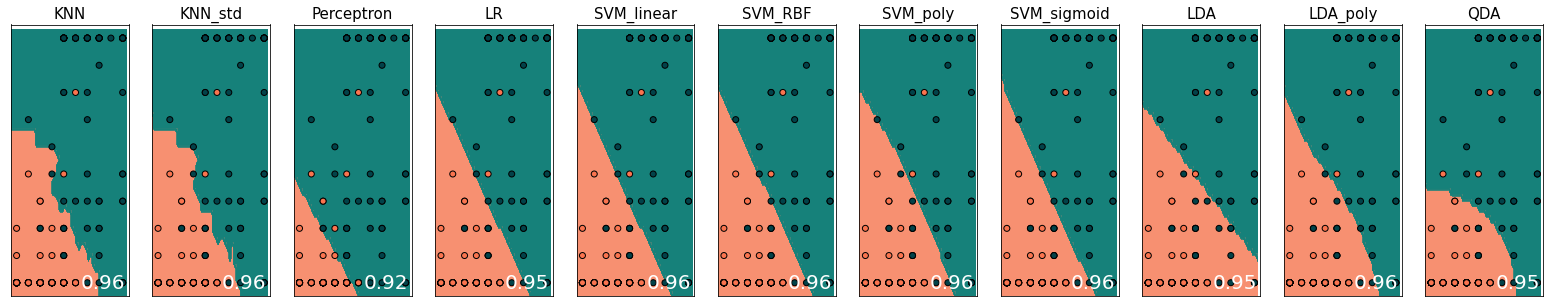

In [55]:
figure = plt.figure(figsize=(30, 5))

i = 1
    
x_min, x_max = X_svm_test[:, 0].min() - .5, X_svm_test[:, 0].max() + .5
y_min, y_max = X_svm_test[:, 1].min() - .5, X_svm_test[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))
X_grid= np.stack([xx.reshape(-1), yy.reshape(-1)], axis=-1)

coma = ListedColormap(['#f79071', '#16817a'])
coma_bright = ListedColormap(['#fa744f', '#024249'])
ax = plt.subplot(1, len(classifiers) + 1, 1)

ax.scatter(X_svm_test[:, 0], X_svm_test[:, 1], c=y_svm_test, cmap=coma_bright, edgecolors='k')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

scores = {}

for name, model, grid_params in classifiers:
    ax = plt.subplot(1, len(classifiers) + 1, i)
    if grid_params is not None:
        grid = GridSearchCV(model, grid_params, cv=5,
                            scoring='accuracy', refit=True, n_jobs=10)
        grid.fit(X_svm_train, y_svm_train)
        model = grid.best_estimator_
        score = grid.best_score_
        parameters = grid.best_params_
        print(f'The best parameters for {name} are:', parameters)
    else:
        model = model.fit(X_svm_train, y_svm_train)
        score = np.mean(cross_val_score(model, X_svm_train, y_svm_train, scoring="accuracy", cv=5))
    scores[name] = score
    
    if hasattr(model, "decision_function"):
        Z = model.decision_function(X_grid)
    else:
        Z = model.predict_proba(X_grid)[:, 1]
        
    Z = model.predict(X_grid)        

    Z = Z.reshape(xx.shape)
        
    ax.pcolormesh(xx, yy, Z, cmap=coma)
    ax.contourf(xx, yy, Z, alpha=.8, cmap=coma)
    
    ax.scatter(X_svm_test[:, 0], X_svm_test[:, 1], c=y_svm_test, cmap=coma_bright, edgecolors='k')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax.set_title(name, size = 15)
    
    ax.text(x_max - .3, y_min + .3,
            ('%.2f' % score),
            size=20, horizontalalignment='right', color="white")
    i += 1

We can then see by the scores, that the best models with two features are the different KNNs and SVM with different kernels. The worst model in this case is the Perceptron (as the data are not linearly separable).

In [56]:
scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse = True)}

print('The sorted models based on the accuracy scores are: \n')
for k, v in scores.items():
    print(f'{k}, with a test accuracy score of: {v} \n')

The sorted models based on the accuracy scores are: 

KNN, with a test accuracy score of: 0.960219298245614 

SVM_RBF, with a test accuracy score of: 0.960219298245614 

SVM_poly, with a test accuracy score of: 0.9581140350877193 

KNN_std, with a test accuracy score of: 0.9580921052631579 

LDA_poly, with a test accuracy score of: 0.956030701754386 

SVM_sigmoid, with a test accuracy score of: 0.9560087719298245 

SVM_linear, with a test accuracy score of: 0.9559868421052631 

LR, with a test accuracy score of: 0.9497149122807018 

LDA, with a test accuracy score of: 0.9477412280701755 

QDA, with a test accuracy score of: 0.9455263157894735 

Perceptron, with a test accuracy score of: 0.9184210526315789 



## Classification metrics

### Confusion Matrix

The Confusion Matrix is a matrix that shows the amount of False and True Negatives and Positives, and then allows to evaluate different models.

First we check the best parameters for each model.

In [57]:
scores = {}
auc_parameters = {}

for name, model, grid_params in classifiers:
    if grid_params is not None:
        grid = GridSearchCV(model, grid_params, cv=5,
                            scoring=make_scorer(roc_auc_score), refit=True, n_jobs=10)
        grid.fit(X_full_train, y_full_train)
        model = grid.best_estimator_
        score = grid.best_score_
        parameters = grid.best_params_
        auc_parameters[name] = parameters
        print(f'The best parameters for {name} are:', parameters)
    else:
        model = model.fit(X_full_train, y_full_train)
        score = np.mean(cross_val_score(model, X_full_train, y_full_train, scoring=make_scorer(roc_auc_score), cv=5))
    scores[name] = score

The best parameters for KNN are: {'n_neighbors': 3}
The best parameters for KNN_std are: {'knn__n_neighbors': 3}
The best parameters for SVM_linear are: {'C': 25.000075}
The best parameters for SVM_RBF are: {'C': 25.00075, 'coef0': -10.0, 'gamma': 0.001}
The best parameters for SVM_poly are: {'C': 0.001, 'coef0': 10.0, 'degree': 3}
The best parameters for SVM_sigmoid are: {'C': 25.00075, 'coef0': 0.0, 'gamma': 0.001}
The best parameters for LDA_poly are: {'poly__degree': 2}


We then build the models with the best parameters.

In [58]:
lr = LogisticRegression()

lda = LDA()

lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA())])

qda = QDA()

poly_svm = SVC(kernel='poly', C = 0.001, coef0 = 10.0, degree = 3,  probability=True)

knn = KNeighborsClassifier(n_neighbors=3)

knn_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))])

linear_svm = SVC(kernel='linear', C = 25.000075,  probability=True)

RBFSVM = SVC(kernel='rbf', C = 25.00075, coef0 = -10.0, gamma = 0.001, probability=True) 

sigmoid_svm = SVC(kernel = 'sigmoid', C=25.00075, coef0 = 0.0, gamma=0.001, probability=True)

We can then plot the different confusion matrixes. We can see that in all models the False Positives and False Negatives are few.

 The confusion matrix of LR is: 


<Figure size 432x288 with 0 Axes>

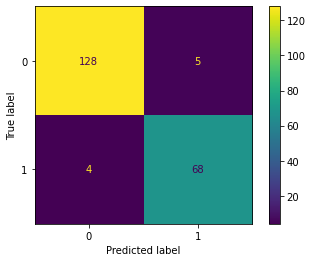

 The confusion matrix of LDA is: 


<Figure size 432x288 with 0 Axes>

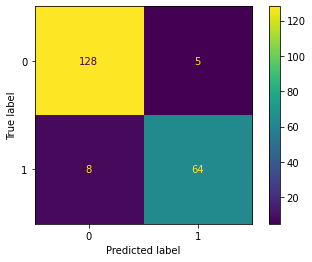

 The confusion matrix of LDA_poly is: 


<Figure size 432x288 with 0 Axes>

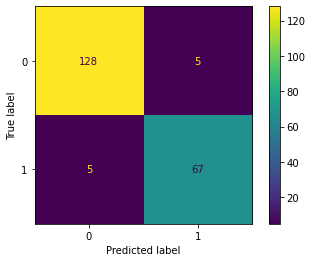

 The confusion matrix of QDA is: 


<Figure size 432x288 with 0 Axes>

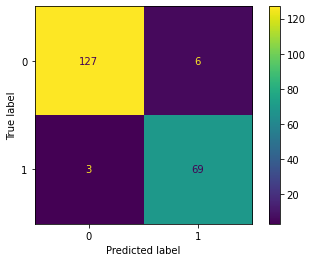

 The confusion matrix of SVM_linear is: 


<Figure size 432x288 with 0 Axes>

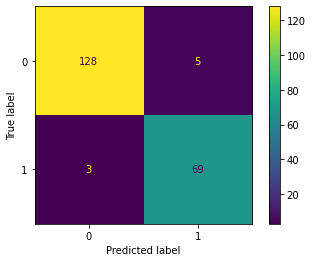

 The confusion matrix of SVM_RBF is: 


<Figure size 432x288 with 0 Axes>

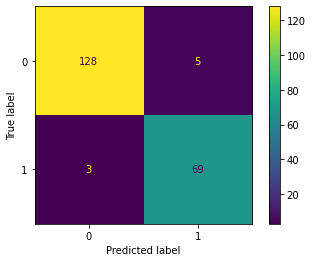

 The confusion matrix of SVM_sigmoid is: 


<Figure size 432x288 with 0 Axes>

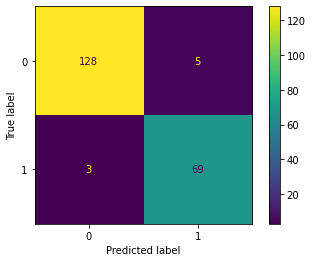

 The confusion matrix of SVM_poly is: 


<Figure size 432x288 with 0 Axes>

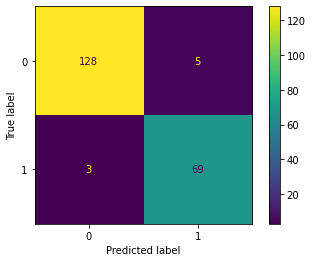

 The confusion matrix of KNN is: 


<Figure size 432x288 with 0 Axes>

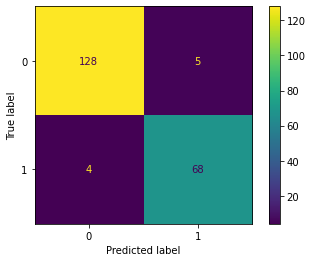

 The confusion matrix of KNN_std is: 


<Figure size 432x288 with 0 Axes>

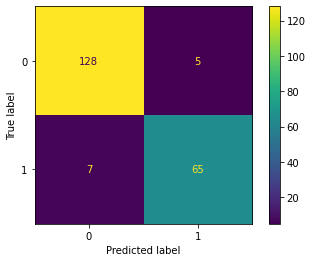

In [59]:
for name, model in [('LR', lr), 
                    ('LDA', lda),
                    ('LDA_poly', lda_poly), 
                    ('QDA', qda),
                    ('SVM_linear', linear_svm),
                    ('SVM_RBF', RBFSVM),
                    ('SVM_sigmoid', sigmoid_svm),
                    ('SVM_poly', poly_svm),
                    ('KNN', knn),
                    ('KNN_std', knn_std)]:
    model.fit(X_full_train, y_full_train)
    cm = confusion_matrix(y_full_test, model.predict(X_full_test))
    
    plt.figure()
    print(f'\033[1;12m The confusion matrix of {name} is: \033[0;0m')
    plot_confusion_matrix(model, X_full_test, y_full_test)
    plt.show()

Since we are in a clinical context in which a False Negative impacts much more than a False Positive, we need to increase as much as possible the sensitivity. In order to do that, we have to employ a lower threshold to discriminate two classes. To find the best threshold, the ROC curve will be helpful.

## ROC curve

The ROC curve is a graph that highlights how sensitivity changes with different thresholds (or different parameters) and can also be used to compare different models. The highest the area under the curve (AUC), the better is the model in classifying. In other words, the curve needs to arrive as close as possible to the left-upper corner.

In [60]:
def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])

    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()

We can then look at the ROC curves of all the different models that we employed, and, by looking at the AUC, compare them.

The area under the ROC curve (AUC) for model LR is: 0.9914369256474519 

The area under the ROC curve (AUC) for model LDA is: 0.9895572263993316 

The area under the ROC curve (AUC) for model LDA_poly is: 0.9886173767752715 

The area under the ROC curve (AUC) for model QDA is: 0.9852756892230576 

The area under the ROC curve (AUC) for model SVM_linear is: 0.9917502088554719 

The area under the ROC curve (AUC) for model SVM_RBF is: 0.9916457811194652 

The area under the ROC curve (AUC) for model SVM_sigmoid is: 0.9926900584795322 

The area under the ROC curve (AUC) for model SVM_poly is: 0.9922723475355054 

The area under the ROC curve (AUC) for model KNN is: 0.964703425229741 

The area under the ROC curve (AUC) for model KNN_std is: 0.9641812865497076 



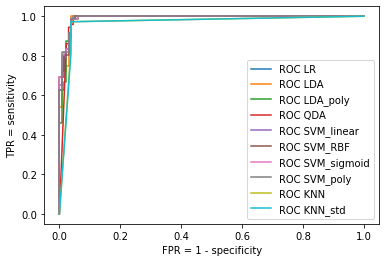

In [61]:
d = {}
for name, model in [('LR', lr), 
                    ('LDA', lda),
                    ('LDA_poly', lda_poly), 
                    ('QDA', qda),
                    ('SVM_linear', linear_svm),
                    ('SVM_RBF', RBFSVM),
                    ('SVM_sigmoid', sigmoid_svm),
                    ('SVM_poly', poly_svm),
                    ('KNN', knn),
                    ('KNN_std', knn_std)]:
    model.fit(X_full_train, y_full_train)
    plot_roc(model.predict_proba, X_full_test, y_full_test, name)
    d[name] = roc_auc_score(y_full_test, model.predict_proba(X_full_test)[:,-1])
    print(f'The area under the ROC curve (AUC) for model {name} is: {roc_auc_score(y_full_test, model.predict_proba(X_full_test)[:,-1])} \n')

We can see from the plot and the area under the ROC curve (displayed below) are all very close to 1. The models that perform the worst are the KNNs, while the best ones are the SVM with different kernels.

In [62]:
roc_scores = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True)}

print('The sorted models based on the test AUC are: \n')
for k, v in roc_scores.items():
    print(f'{k}, with an AUC of: {v} \n')

The sorted models based on the test AUC are: 

SVM_sigmoid, with an AUC of: 0.9926900584795322 

SVM_poly, with an AUC of: 0.9922723475355054 

SVM_linear, with an AUC of: 0.9917502088554719 

SVM_RBF, with an AUC of: 0.9916457811194652 

LR, with an AUC of: 0.9914369256474519 

LDA, with an AUC of: 0.9895572263993316 

LDA_poly, with an AUC of: 0.9886173767752715 

QDA, with an AUC of: 0.9852756892230576 

KNN, with an AUC of: 0.964703425229741 

KNN_std, with an AUC of: 0.9641812865497076 



## Accuracy barplot

If we look then at the accuracy scores of the different techniques on the full features model, we can see that we have a general increase with respect to the 2-features model, but the Perceptron (which works better in the separable case) performs worse than the others and worse than the 2-features case. Again, the different SVM models are the ones that in general perform better, but also KNN performs very well. The QDA is the worst model.

In [63]:
scores = {}
accuracy_parameters = {}

for name, model, grid_params in classifiers:
    if grid_params is not None:
        grid = GridSearchCV(model, grid_params, cv=5,
                            scoring='accuracy', refit=True, n_jobs=10)
        grid.fit(X_full_train, y_full_train)
        model = grid.best_estimator_
        score = grid.best_score_
        parameters = grid.best_params_
        accuracy_parameters[name] = parameters
        print(f'The best parameters for {name} are:', parameters)
    else:
        model = model.fit(X_full_train, y_full_train)
        score = np.mean(cross_val_score(model, X_full_train, y_full_train, scoring="accuracy", cv=5))
    scores[name] = score
    
    
accuracy_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse = True)}

print('\n')
print('The sorted models based on the accuracy scores are: \n')
for k, v in accuracy_scores.items():
    print(f'{k}, with an accuracy score of: {v} \n')

The best parameters for KNN are: {'n_neighbors': 3}
The best parameters for KNN_std are: {'knn__n_neighbors': 3}
The best parameters for SVM_linear are: {'C': 25.000075}
The best parameters for SVM_RBF are: {'C': 25.00075, 'coef0': -10.0, 'gamma': 0.001}
The best parameters for SVM_poly are: {'C': 0.001, 'coef0': 10.0, 'degree': 3}
The best parameters for SVM_sigmoid are: {'C': 25.00075, 'coef0': 0.0, 'gamma': 0.001}
The best parameters for LDA_poly are: {'poly__degree': 2}


The sorted models based on the accuracy scores are: 

KNN, with an accuracy score of: 0.9769736842105263 

SVM_RBF, with an accuracy score of: 0.9728070175438596 

SVM_poly, with an accuracy score of: 0.9728070175438596 

SVM_sigmoid, with an accuracy score of: 0.9728070175438596 

KNN_std, with an accuracy score of: 0.9727412280701755 

LR, with an accuracy score of: 0.9707236842105263 

LDA, with an accuracy score of: 0.9665350877192983 

SVM_linear, with an accuracy score of: 0.9644298245614035 

LDA_poly, with

We can then plot a barplot that shows the different accuracy scores on the test and with a 5-folds CV, using the models with the best parameters as selected above.

logistic CV score: 0.9707,  test score 0.9561
lda CV score: 0.9665,  test score 0.9366
lda_poly CV score: 0.9561,  test score 0.9512
qda CV score: 0.9477,  test score 0.9561
knn CV score: 0.9770,  test score 0.9561
knn_std CV score: 0.9727,  test score 0.9415
perceptron CV score: 0.9540,  test score 0.9512
linear_svm CV score: 0.9644,  test score 0.9610
svm_rbf CV score: 0.9728,  test score 0.9610
svm_poly CV score: 0.9728,  test score 0.9610
svm_sigmoid CV score: 0.9728,  test score 0.9610


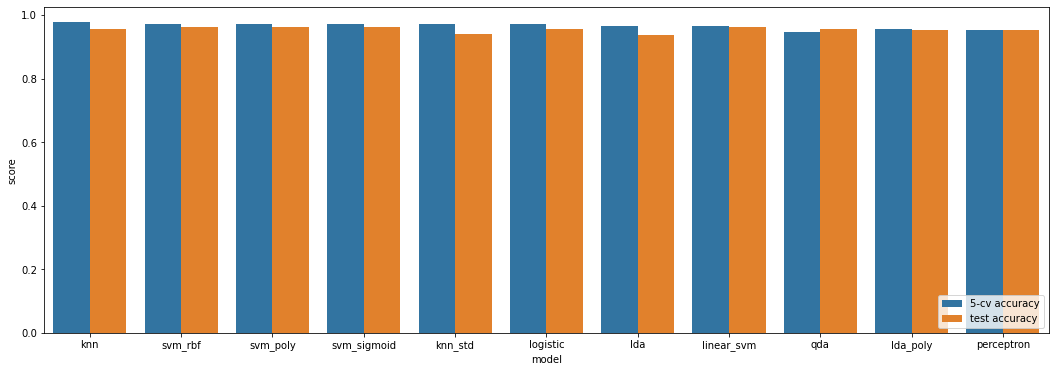

In [64]:
knn = KNeighborsClassifier(3)

knn_std = Pipeline([('norm', StandardScaler()), ('knn', KNeighborsClassifier(3))])

perceptron = Perceptron()

logistic = LogisticRegression(fit_intercept=True, max_iter = 100000)

linear_svm = SVC(kernel='linear', C = 25.000075)

svm_rbf = SVC(kernel='rbf', C = 25.00075, coef0 = -10.0, gamma = 0.001)

svm_poly = SVC(kernel='poly', C = 0.001, coef0 = 10.0, degree = 3)

svm_sigmoid = SVC(kernel='sigmoid', C = 25.00075, coef0 = 0.0, gamma = 0.001)

lda = LDA()
     
lda_poly = Pipeline([('poly', PolynomialFeatures(2)), 
                          ('lda', LDA())])

qda = QDA()
    
models = OrderedDict([('logistic', logistic), ('lda', lda), ('lda_poly', lda_poly), ('qda', qda),
                      ('knn', knn), ('knn_std', knn_std), ('perceptron', perceptron), 
                      ('linear_svm', linear_svm), ('svm_rbf', svm_rbf), ('svm_poly', svm_poly), ('svm_sigmoid', svm_sigmoid)
                     ])


cv_scores, test_scores = [], []

for name, model in models.items():
    scores = cross_val_score(model, X_full_train, y_full_train, cv=5, scoring = 'accuracy')
    cv_score = np.mean(scores)
    cv_scores.append(cv_score)
    
    model.fit(X_full_train, y_full_train)
    test_score = accuracy(y_full_test, model.predict(X_full_test))
    test_scores.append(test_score)
    print("{} CV score: {:.4f},  test score {:.4f}".format(name, cv_score, test_score))

data = pd.DataFrame()
data['model'] = list(models.keys()) * 2
data['metric'] = ['5-cv accuracy'] * len(cv_scores) + ['test accuracy'] * len(test_scores)
data['score'] = cv_scores + test_scores

data = data.sort_values('score', ascending=False)

fig_dims = (18, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='model', y='score', data=data, hue='metric', ax = ax)
plt.legend(loc='lower right')

## Recall barplot

We can then identify the best models for what regards the recall (or sensitivity), which, as said before, might be the score to consider in a clinical context, in which we want to minimize the False Negatives. 
First, we identify the best parameters.

In [65]:
scores = {}
recall_parameters = {}

for name, model, grid_params in classifiers:
    if grid_params is not None:
        grid = GridSearchCV(model, grid_params, cv=5,
                            scoring='recall', refit=True, n_jobs=10)
        grid.fit(X_full_train, y_full_train)
        model = grid.best_estimator_
        score = grid.best_score_
        parameters = grid.best_params_
        recall_parameters[name] = parameters
        print(f'The best parameters for {name} are:', parameters)
    else:
        model = model.fit(X_full_train, y_full_train)
        score = np.mean(cross_val_score(model, X_full_train, y_full_train, scoring="recall", cv=5))
    scores[name] = score
    
    
recall_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse = True)}

print('\n')
print('The sorted models based on the recall scores are: \n')
for k, v in recall_scores.items():
    print(f'{k}, with a recall score of: {v} \n')

The best parameters for KNN are: {'n_neighbors': 3}
The best parameters for KNN_std are: {'knn__n_neighbors': 3}
The best parameters for SVM_linear are: {'C': 25.000075}
The best parameters for SVM_RBF are: {'C': 25.00075, 'coef0': -10.0, 'gamma': 0.001}
The best parameters for SVM_poly are: {'C': 0.001, 'coef0': -10.0, 'degree': 3}
The best parameters for SVM_sigmoid are: {'C': 25.00075, 'coef0': 0.0, 'gamma': 0.001}
The best parameters for LDA_poly are: {'poly__degree': 2}


The sorted models based on the recall scores are: 

QDA, with a recall score of: 0.9878787878787879 

SVM_linear, with a recall score of: 0.9582887700534759 

SVM_poly, with a recall score of: 0.9582887700534759 

SVM_RBF, with a recall score of: 0.9581105169340465 

SVM_sigmoid, with a recall score of: 0.9581105169340465 

KNN, with a recall score of: 0.9579322638146166 

LR, with a recall score of: 0.95222816399287 

KNN_std, with a recall score of: 0.9518716577540107 

Perceptron, with a recall score of: 0.946

Then, we build them and plot the barplot.

logistic CV score: 0.9522,  test score 0.9444
lda CV score: 0.9223,  test score 0.8889
lda_poly CV score: 0.9159,  test score 0.9306
qda CV score: 0.9879,  test score 0.9583
knn CV score: 0.9579,  test score 0.9444
knn_std CV score: 0.9519,  test score 0.9028
perceptron CV score: 0.9467,  test score 0.9306
linear_svm CV score: 0.9583,  test score 0.9583
svm_rbf CV score: 0.9581,  test score 0.9583
svm_poly CV score: 0.9583,  test score 0.9583
svm_sigmoid CV score: 0.9581,  test score 0.9583


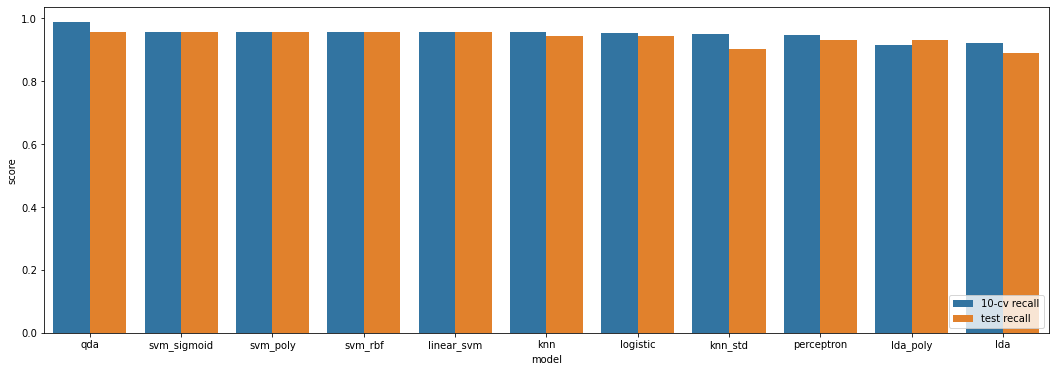

In [66]:
knn = KNeighborsClassifier(3)

knn_std = Pipeline([('norm', StandardScaler()), ('knn', KNeighborsClassifier(3))])

perceptron = Perceptron()

logistic = LogisticRegression(fit_intercept=True, max_iter = 100000)

linear_svm = SVC(kernel='linear', C = 25.000075)

svm_rbf = SVC(kernel='rbf', C =  25.00075, coef0 = -10.0, gamma = 0.001)

svm_poly = SVC(kernel='poly', C = 0.001, coef0 = -10.0, degree = 3)

svm_sigmoid = SVC(kernel='sigmoid', C = 25.00075, coef0 = 0.0, gamma = 0.001) 

lda = LDA()
     
lda_poly = Pipeline([('poly', PolynomialFeatures(2)), 
                          ('lda', LDA())])

qda = QDA()
    
models = OrderedDict([('logistic', logistic), ('lda', lda), ('lda_poly', lda_poly), ('qda', qda),
                      ('knn', knn), ('knn_std', knn_std), ('perceptron', perceptron), 
                      ('linear_svm', linear_svm), ('svm_rbf', svm_rbf), ('svm_poly', svm_poly), ('svm_sigmoid', svm_sigmoid)
                     ])


cv_scores, test_scores = [], []

for name, model in models.items():
    scores = cross_val_score(model, X_full_train, y_full_train, cv=5, scoring = 'recall')
    cv_score = np.mean(scores)
    cv_scores.append(cv_score)
    
    model.fit(X_full_train, y_full_train)
    test_score = recall_score(y_full_test, model.predict(X_full_test))
    test_scores.append(test_score)
    print("{} CV score: {:.4f},  test score {:.4f}".format(name, cv_score, test_score))

data = pd.DataFrame()
data['model'] = list(models.keys()) * 2
data['metric'] = ['10-cv recall'] * len(cv_scores) + ['test recall'] * len(test_scores)
data['score'] = cv_scores + test_scores

data = data.sort_values('score', ascending=False)

fig_dims = (18, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='model', y='score', data=data, hue='metric', ax = ax)
plt.legend(loc='lower right')

We can see that the QDA model is the best for what regard the recall, and in general all the SVM models perform well. The Perceptron and the LDA models are instead the worst.

## Overall best parameters

If instead of finding the parameters for the model that guarantee the highest score in either accuracy, AUC or recall, regardless of the other scores, we want to find the overall best parameters, we have to find the best compromise. First, we have to find out, between the models considered, which ones have parameters that differ when considering the different scores: we can see a general agreement, a part from the polynomial SVM.

In [67]:
difp_models = [x for x in auc_parameters if auc_parameters[x] not in accuracy_parameters.values() or auc_parameters[x] not in recall_parameters.values()]

for x in difp_models:
    print(x)
    print(auc_parameters[x])
    print(accuracy_parameters[x])
    print(recall_parameters[x])

SVM_poly
{'C': 0.001, 'coef0': 10.0, 'degree': 3}
{'C': 0.001, 'coef0': 10.0, 'degree': 3}
{'C': 0.001, 'coef0': -10.0, 'degree': 3}


We can then compare the two models with the two different sets of parameters, by looking at a barplot with the accuracy, AUC and recall scores.

SVM_poly_1 roc score: [0.9694290423891943], accuracy score [0.9728070175438596], recall score [0.9581105169340465]
SVM_poly_2 roc score: [0.963092157684188], accuracy score [0.9644298245614035], recall score [0.9582887700534759]


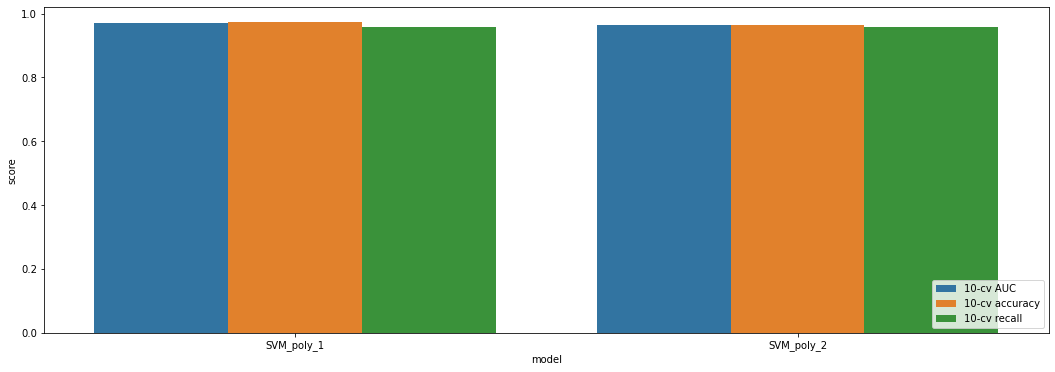

In [68]:
SVM_poly_1 = SVC(kernel='poly', C = 0.001, coef0 = 10.0, degree = 3)
SVM_poly_2 = SVC(kernel='poly', C = 0.001, coef0 = -10.0, degree = 3)

models = OrderedDict([('SVM_poly_1', SVM_poly_1), ('SVM_poly_2', SVM_poly_2)
                     ])

roc_scores, accuracy_scores, recall_scores = [], [], []

for name, model in models.items():
    roc_s, accuracy_s, recall_s = [], [], []
    
    scores = cross_val_score(model, X_full_train, y_full_train, cv=5, scoring = make_scorer(roc_auc_score))
    cv_score = np.mean(scores)
    roc_s.append(cv_score)
    roc_scores.append(cv_score)
    
    scores = cross_val_score(model, X_full_train, y_full_train, cv=5, scoring = 'accuracy')
    cv_score = np.mean(scores)
    accuracy_s.append(cv_score)
    accuracy_scores.append(cv_score)
    
    scores = cross_val_score(model, X_full_train, y_full_train, cv=5, scoring = 'recall')
    cv_score = np.mean(scores)
    recall_s.append(cv_score)
    recall_scores.append(cv_score)
    
    print(f"{name} roc score: {roc_s}, accuracy score {accuracy_s}, recall score {recall_s}")

        
data = pd.DataFrame()
data['model'] =  list(models.keys()) * 3
data['metric'] = ['10-cv AUC'] * len(roc_scores) + ['10-cv accuracy'] * len(accuracy_scores) + ['10-cv recall'] * len(recall_scores)
data['score'] = roc_scores + accuracy_scores + recall_scores

fig_dims = (18, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='model', y='score', data=data, hue='metric', ax = ax)
plt.legend(loc='lower right')

The first model has higher scores for what regards everything, apart from a sligthly lower recall.

### The best models

The overall best models are the following:

In [69]:
knn = KNeighborsClassifier(3)

knn_std = Pipeline([('norm', StandardScaler()), ('knn', KNeighborsClassifier(3))])

perceptron = Perceptron()

logistic = LogisticRegression(fit_intercept=True, max_iter = 100000)

linear_svm = SVC(kernel='linear', C = 25.000075, probability = True)

svm_rbf = SVC(kernel='rbf', C =  25.00075, coef0 = -10.0, gamma = 0.001, probability = True)

svm_poly = SVC(kernel='poly', C = 0.001, coef0 = -10.0, degree = 3, probability = True)

svm_sigmoid = SVC(kernel='sigmoid', C = 25.00075, coef0 = 0.0, gamma = 0.001, probability = True) 

lda = LDA()
     
lda_poly = Pipeline([('poly', PolynomialFeatures(2)), 
                          ('lda', LDA())])

qda = QDA()

## Scores summary

Lastly, we can look at the order of the different models with respect to the accuracy, the AUC and the recall (potentially there are also the precision, F1 and other metrics that can be considered), to see if there are relevant differences. The scores are computed with a 5-fold cross validation.

In [70]:
auc_scores = {}
accuracy_scores = {}
recall_scores = {}

for name, model in [('LR', lr), 
                    ('LDA', lda),
                    ('LDA_poly', lda_poly), 
                    ('QDA', qda),
                    ('SVM_linear', linear_svm),
                    ('SVM_RBF', RBFSVM),
                    ('SVM_sigmoid', sigmoid_svm),
                    ('SVM_poly', poly_svm),
                    ('KNN', knn),
                    ('KNN_std', knn_std),
                    ('Perceptron', perceptron)]:
    
    model.fit(X_full_train, y_full_train)
    
    auc_score = np.mean(cross_val_score(model, X_full_train, y_full_train, scoring = make_scorer(roc_auc_score), cv=5))
    auc_scores[name] = auc_score
    auc_scores = {k: v for k, v in sorted(auc_scores.items(), key=lambda item: item[1], reverse = True)}

    
    acc_score = np.mean(cross_val_score(model, X_full_train, y_full_train, scoring="accuracy", cv=5))
    accuracy_scores[name] = acc_score
    accuracy_scores = {k: v for k, v in sorted(accuracy_scores.items(), key=lambda item: item[1], reverse = True)}
    
    recall_score = np.mean(cross_val_score(model, X_full_train, y_full_train, scoring="recall", cv=5))
    recall_scores[name] = recall_score
    recall_scores = {k: v for k, v in sorted(recall_scores.items(), key=lambda item: item[1], reverse = True)}

In [71]:
ordered_models = pd.DataFrame({'AUC model': auc_scores.keys(), 'AUC score': auc_scores.values(), 'Accuracy model': accuracy_scores.keys(), 'Accuracy score': accuracy_scores.values(), 'Recall model': recall_scores.keys(), 'Recall score': recall_scores.values(), 'Order' : ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th']})
ordered_models = ordered_models.set_index('Order')

ordered_models

,AUC model,AUC score,Accuracy model,Accuracy score,Recall model,Recall score
Order,,,,,,
1st,KNN,0.972540,KNN,0.976974,QDA,0.987879
2nd,SVM_RBF,0.969429,SVM_RBF,0.972807,SVM_linear,0.958289
3rd,SVM_sigmoid,0.969429,SVM_sigmoid,0.972807,SVM_RBF,0.958111
4th,SVM_poly,0.969429,SVM_poly,0.972807,SVM_sigmoid,0.958111
5th,KNN_std,0.967897,KNN_std,0.972741,SVM_poly,0.958111
6th,LR,0.966462,LR,0.970724,KNN,0.957932
7th,SVM_linear,0.963067,LDA,0.966535,LR,0.952228
8th,QDA,0.957073,SVM_linear,0.964430,KNN_std,0.951872
9th,LDA,0.956302,LDA_poly,0.956053,Perceptron,0.946702


# Conclusions

We can conclude that the features provided to diagnose breast cancer are very accurate with most models, also when considering a model that has undergone feature selection: the model with bare nuclei and clump thickness only, which was used for representation porpuses, but in the end gave high accuracy scores with almost every model.

By looking at the last table, we can see that in general the different SVM models have the second highest AUC with respect to the other models (second to only KNN), and also their recall and accuracy are one of the highest (second only to QDA in the recall rankings and to KNN in the accuracy ones). We can see that the unnurmalized KNN is always higher in ranking compared to the standardized KNN, and it is actually the best model for accuracy and AUC, while it performs not so well in the recall. The QDA is the worst model in accuracy and has low rankings also for AUC, while it has the highest recall. Logistic Regression has middle rankings in all three scores. LDA and its polynomial counterpart have in general low rankings and are actually the worst in recall. The Perceptron is always one of the worst.

The SVM is overall the more robust model, because the KNN has a much lower recall, that is much more relevant in a clinical case. The polynomial, sigmoid and RBF kernels perform in exactly the same way, while the linear SVM performs always worse.

The generally worse performance (compared to the other models) of the LDA, the Logistic Regression and the QDA (apart from recall) models might be due to the assumptions that underlie the techniques: for LDA and QDA the distribution of the features has to be gaussian, and for the LDA the variance has to be the same across the features, while for Logistic Regression data has to be linearly separable.

We can in general see that the models have small differences, and they all perform very well.